In [1]:
!pip install pdfplumber -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.5/42.5 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 35.8 MB/s eta 0:00:00


In [2]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"TPU device successfully initialized: {device}")

TPU device successfully initialized: cuda


In [ ]:
# Import necessary libraries
#!pip install pennylane -q
import torch
import pennylane as qml
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
# Define the Variational Quantum Autoencoder (VQAE)
class VQAE:
    def __init__(self, n_qubits=4, n_layers=3):
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.dev = qml.device("default.qubit", wires=n_qubits)
        self.weights = np.random.rand(n_layers, n_qubits)

    def preprocess_text(self, text):
        """Preprocess text into a numerical array for the quantum circuit."""
        # Example: Convert text to a numerical array using a simple embedding
        # Here, we use a simple character-level embedding (ASCII values)
        # You can replace this with more sophisticated embeddings (e.g., word embeddings)
        numerical_data = np.array([ord(char) for char in text[:self.n_qubits]])  # Use first n_qubits characters
        numerical_data = numerical_data / 255.0  # Normalize to [0, 1]
        return numerical_data

    def quantum_circuit(self, inputs):
        """Quantum circuit for encoding."""
        qml.templates.AngleEmbedding(inputs, wires=range(self.n_qubits))
        qml.templates.BasicEntanglerLayers(self.weights, wires=range(self.n_qubits))
        return [qml.expval(qml.PauliZ(i)) for i in range(self.n_qubits)]

    def encode(self, data):
        """Encode classical data using the quantum circuit."""
        # Preprocess the text data into a numerical array
        numerical_data = self.preprocess_text(data)
        qnode = qml.QNode(self.quantum_circuit, self.dev)
        encoded_data = qnode(numerical_data)
        return torch.tensor(encoded_data, dtype=torch.float32)

In [7]:
def get_sentiment_score(text, device):
    """Get sentiment score as normalized probabilities using FinBERT with TPU support."""
    if not text.strip():
        return [0.33, 0.33, 0.33]  # Neutral probabilities for empty text

    # Use direct model loading for TPU compatibility
    from transformers import AutoTokenizer, AutoModelForSequenceClassification
    import torch
    import torch.nn.functional as F

    # Load model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
    model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
    model = model.to(device)

    # Tokenize input
    inputs = tokenizer(text[:512], return_tensors="pt", padding=True, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Run inference
    with torch.no_grad():
        outputs = model(**inputs)

    # Apply softmax to get probabilities
    probabilities = F.softmax(outputs.logits, dim=-1).cpu().numpy()[0]
    return probabilities

In [8]:
# Function to analyze transcript with FinBERT
def analyze_transcript_with_model(transcript_text, device):
    """Analyze financial transcript using FinBERT."""
    from transformers import AutoTokenizer, AutoModelForSequenceClassification
    import torch
    import torch.nn.functional as F

    # Load FinBERT model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
    model = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")
    model = model.to(device)

    # Truncate or split the text if it exceeds 512 tokens
    max_length = 512
    inputs = tokenizer(
        transcript_text,
        return_tensors="pt",
        truncation=True,
        max_length=max_length,
        padding=True
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Run inference
    with torch.no_grad():
        outputs = model(**inputs)

    # Apply softmax to get probabilities
    probabilities = F.softmax(outputs.logits, dim=-1).cpu().numpy()[0]
    return probabilities

# Function to analyze transcript with FinBERT and handle long texts
def analyze_long_transcript_with_finbert(transcript_text, device):
    """Analyze long financial transcript using FinBERT by splitting into chunks."""
    from transformers import AutoTokenizer, AutoModelForSequenceClassification
    import torch
    import torch.nn.functional as F

    # Load FinBERT model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
    model = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")
    model = model.to(device)

    # Split the text into chunks of 512 tokens
    max_length = 512
    chunks = [transcript_text[i:i + max_length] for i in range(0, len(transcript_text), max_length)]

    # Initialize a list to store probabilities
    all_probabilities = []

    for chunk in chunks:
        inputs = tokenizer(
            chunk,
            return_tensors="pt",
            truncation=True,
            max_length=max_length,
            padding=True
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Run inference
        with torch.no_grad():
            outputs = model(**inputs)

        # Apply softmax to get probabilities
        probabilities = F.softmax(outputs.logits, dim=-1).cpu().numpy()[0]
        all_probabilities.append(probabilities)

    # Average the probabilities across all chunks
    avg_probabilities = np.mean(all_probabilities, axis=0)
    return avg_probabilities

In [9]:
# Set up a modern financial analysis model
def setup_financial_llm(device):
    """Set up a financial-optimized LLM (Mistral 7B fine-tuned for finance)."""
    print("Setting up financial analysis model...")

    # Using a financial-tuned Mistral variant
    #model_name = "yiyanghkust/finbert-tone"
    model_name = "ProsusAI/finbert"

    # Configuration for financial analysis
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.bfloat16,
        #device_map="auto",
        trust_remote_code=True
    ).to(device)

    print(f"Financial model {model_name} loaded successfully")
    return {"model": model, "tokenizer": tokenizer}

In [10]:
# Keep your original PDF extraction function
def extract_text_from_pdf(pdf_source):
    """Extract text from a PDF file (either URL or local path)."""
    import pdfplumber
    import requests
    from io import BytesIO

    if isinstance(pdf_source, str) and pdf_source.startswith("http"):
        response = requests.get(pdf_source)
        if response.status_code != 200:
            print(f"❌ Failed to download: {pdf_source}")
            return ""
        pdf_content = BytesIO(response.content)
    else:
        pdf_content = pdf_source  # Local file path

    try:
        with pdfplumber.open(pdf_content) as pdf:
            text = "\n".join(page.extract_text() for page in pdf.pages if page.extract_text())
        return text
    except Exception as e:
        print(f"Error extracting text: {e}")
        return ""

In [11]:
# Function to analyze all documents with VQAE
def analyze_all_documents_with_vqae(company_files, device):
    """Analyze all documents (transcript, financial statement, news) using VQAE and FinBERT."""
    import pandas as pd
    from tqdm import tqdm

    vqae = VQAE()

    data = []
    for company, quarters in tqdm(company_files.items(), desc="Processing Companies"):
        for quarter, files in quarters.items():
            news_csv, report_pdf, concall_pdf = files

            print(f"Processing {company} {quarter}...")
            report_text = extract_text_from_pdf(report_pdf)
            transcript_text = extract_text_from_pdf(concall_pdf)

            news_text = ""
            if news_csv:
                try:
                    news_df = pd.read_json("/content/infosys_articles_gnews.json")
                    news_text = " ".join(news_df["title"].tolist())
                except Exception as e:
                    print(f"Error loading news JSON: {e}")

            combined_text = f"{transcript_text} {report_text} {news_text}"

            encoded_text = vqae.encode(combined_text)

            if len(combined_text) > 512:
                sentiment_score = analyze_long_transcript_with_finbert(combined_text, device)
            else:
                sentiment_score = analyze_transcript_with_finbert(combined_text, device)

            data.append([company, quarter, encoded_text, sentiment_score])

    df = pd.DataFrame(data, columns=["Company", "Quarter", "Encoded Text", "Combined Sentiment"])
    df.to_csv("vqae_finbert_combined_data.csv", index=False)
    print("✅ Process Completed. Data saved to vqae_finbert_combined_data.csv")
    return df

In [12]:
def load_and_preprocess_stock_data(csv_path):
    """Load and preprocess stock price data from CSV."""
    df = pd.read_csv(csv_path)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')
    # Extract quarter as 'Q1', 'Q2', etc.
    df['Quarter'] = 'Q' + df['Date'].dt.quarter.astype(str)
    df['Price_Change'] = df['Close Price'].pct_change() * 100
    df['7D_MA'] = df['Close Price'].rolling(window=7).mean()
    return df

In [13]:
def analyze_sentiment_stock_correlation(company_files, stock_csv_path, device):
    """Analyze correlation between VQAE embeddings and stock prices."""
    stock_df = load_and_preprocess_stock_data(stock_csv_path)
    vqae_results = analyze_all_documents_with_vqae(company_files, device)

    # Merge on the 'Quarter' column
    merged_data = pd.merge(vqae_results, stock_df,
                         on='Quarter',  # Changed to merge on 'Quarter' column
                         how='inner')

    correlations = {}
    n_qubits = len(vqae_results['Encoded Text'].iloc[0])

    for i in range(n_qubits):
        correlations[f'VQAE_Feature_{i}_vs_Price'] = np.corrcoef(
            merged_data['Encoded Text'].apply(lambda x: x[i].item()),
            merged_data['Close Price']
        )[0, 1]

    return merged_data, correlations

In [14]:
# Modified visualization
def visualize_correlation(merged_data):
    """Visualize VQAE embeddings and stock price relationship."""
    plt.figure(figsize=(15, 7))

    plt.plot(merged_data['Date'], merged_data['Close Price'],
            label='Stock Price', color='blue', linewidth=2)

    colors = ['green', 'red', 'purple', 'orange']
    n_qubits = len(merged_data['Encoded Text'].iloc[0])

    for i in range(n_qubits):
        plt.plot(merged_data['Date'],
                merged_data['Encoded Text'].apply(lambda x: x[i].item()),
                label=f'Qubit {i} Embedding',
                linestyle='--',
                color=colors[i % len(colors)])

    plt.title('Stock Price vs Quantum Embeddings')
    plt.xlabel('Date')
    plt.ylabel('Normalized Values')
    plt.legend()
    plt.grid(True)
    plt.show()

In [15]:
# Main function
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    company_files = {
        "Company_A": {
            "Q1": (
                "/content/infosys_combined.csv",
                "/content/finstatement.pdf",
                "/content/earningscall.pdf"
            ),
        }
    }

    analyze_all_documents_with_vqae(company_files, device)

    merged_data, correlations = analyze_sentiment_stock_correlation(
        company_files, "/content/infosys_combined.csv", device
    )

    print("\n=== Quantum Embedding Correlations ===")
    for k, v in correlations.items():
        print(f"{k}: {v:.4f}")

    visualize_correlation(merged_data)

Processing Companies:   0%|          | 0/1 [00:00<?, ?it/s]

Processing Company_A Q1...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

Processing Companies: 100%|██████████| 1/1 [00:39<00:00, 39.79s/it]
<ipython-input-12-e56e8a867818>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


✅ Process Completed. Data saved to vqae_finbert_combined_data.csv


Processing Companies:   0%|          | 0/1 [00:00<?, ?it/s]

Processing Company_A Q1...


Processing Companies: 100%|██████████| 1/1 [00:17<00:00, 17.16s/it]
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


✅ Process Completed. Data saved to vqae_finbert_combined_data.csv

=== Quantum Embedding Correlations ===
VQAE_Feature_0_vs_Price: nan
VQAE_Feature_1_vs_Price: nan
VQAE_Feature_2_vs_Price: nan
VQAE_Feature_3_vs_Price: nan


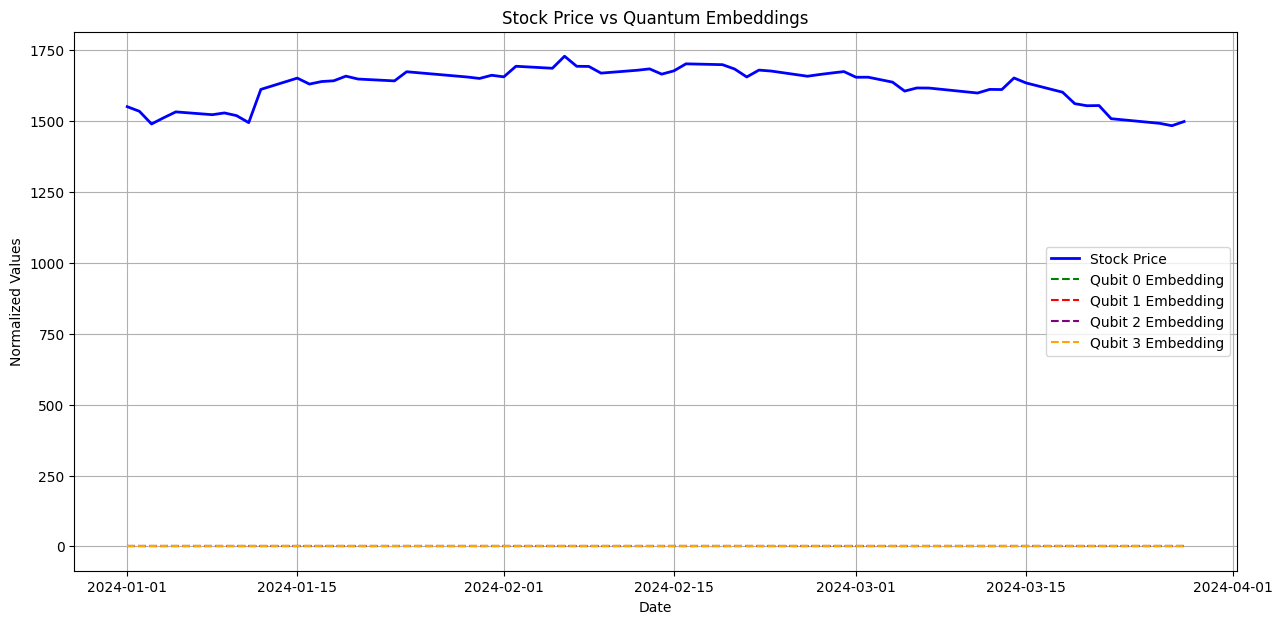

In [16]:
if __name__ == "__main__":
    main()